In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:57 - loss: 0.1533 - STD: 2.8746e-04 - MAE: 0.3795

 4/80 [>.............................] - ETA: 2s - loss: 0.0513 - STD: 4.8802e-04 - MAE: 0.1733  

 5/80 [>.............................] - ETA: 2s - loss: 0.0456 - STD: 4.3505e-04 - MAE: 0.1625

 6/80 [=>............................] - ETA: 3s - loss: 0.0425 - STD: 3.8644e-04 - MAE: 0.1579

 7/80 [=>............................] - ETA: 3s - loss: 0.0404 - STD: 3.4538e-04 - MAE: 0.1553

 8/80 [==>...........................] - ETA: 3s - loss: 0.0391 - STD: 3.1120e-04 - MAE: 0.1538

 9/80 [==>...........................] - ETA: 3s - loss: 0.0381 - STD: 2.8248e-04 - MAE: 0.1529

10/80 [==>...........................] - ETA: 3s - loss: 0.0374 - STD: 2.5823e-04 - MAE: 0.1522

11/80 [===>..........................] - ETA: 3s - loss: 0.0367 - STD: 2.3750e-04 - MAE: 0.1515

12/80 [===>..........................] - ETA: 3s - loss: 0.0361 - STD: 2.1964e-04 - MAE: 0.1507

13/80 [===>..........................] - ETA: 3s - loss: 0.0354 - STD: 2.0418e-04 - MAE: 0.1498

14/80 [====>.........................] - ETA: 3s - loss: 0.0349 - STD: 1.9086e-04 - MAE: 0.1489

15/80 [====>.........................] - ETA: 3s - loss: 0.0343 - STD: 1.7947e-04 - MAE: 0.1476

16/80 [=====>........................] - ETA: 3s - loss: 0.0336 - STD: 1.6980e-04 - MAE: 0.1460

17/80 [=====>........................] - ETA: 3s - loss: 0.0329 - STD: 1.6159e-04 - MAE: 0.1442

18/80 [=====>........................] - ETA: 3s - loss: 0.0321 - STD: 1.5468e-04 - MAE: 0.1421

19/80 [======>.......................] - ETA: 3s - loss: 0.0313 - STD: 1.4893e-04 - MAE: 0.1396

20/80 [======>.......................] - ETA: 3s - loss: 0.0305 - STD: 1.4419e-04 - MAE: 0.1370

21/80 [======>.......................] - ETA: 3s - loss: 0.0296 - STD: 1.4034e-04 - MAE: 0.1343

22/80 [=======>......................] - ETA: 3s - loss: 0.0287 - STD: 1.3727e-04 - MAE: 0.1316

23/80 [=======>......................] - ETA: 3s - loss: 0.0279 - STD: 1.3485e-04 - MAE: 0.1291

24/80 [========>.....................] - ETA: 3s - loss: 0.0271 - STD: 1.3294e-04 - MAE: 0.1270

25/80 [========>.....................] - ETA: 3s - loss: 0.0264 - STD: 1.3130e-04 - MAE: 0.1252

26/80 [========>.....................] - ETA: 3s - loss: 0.0258 - STD: 1.2986e-04 - MAE: 0.1239

27/80 [=========>....................] - ETA: 2s - loss: 0.0253 - STD: 1.2846e-04 - MAE: 0.1228

28/80 [=========>....................] - ETA: 2s - loss: 0.0249 - STD: 1.2697e-04 - MAE: 0.1220

29/80 [=========>....................] - ETA: 2s - loss: 0.0245 - STD: 1.2534e-04 - MAE: 0.1211

30/80 [==========>...................] - ETA: 2s - loss: 0.0241 - STD: 1.2354e-04 - MAE: 0.1202

31/80 [==========>...................] - ETA: 2s - loss: 0.0236 - STD: 1.2160e-04 - MAE: 0.1191

32/80 [===========>..................] - ETA: 2s - loss: 0.0232 - STD: 1.1954e-04 - MAE: 0.1181

33/80 [===========>..................] - ETA: 2s - loss: 0.0228 - STD: 1.1739e-04 - MAE: 0.1169

34/80 [===========>..................] - ETA: 2s - loss: 0.0224 - STD: 1.1524e-04 - MAE: 0.1157

35/80 [============>.................] - ETA: 2s - loss: 0.0220 - STD: 1.1310e-04 - MAE: 0.1145

36/80 [============>.................] - ETA: 2s - loss: 0.0217 - STD: 1.1103e-04 - MAE: 0.1134

37/80 [============>.................] - ETA: 2s - loss: 0.0214 - STD: 1.0906e-04 - MAE: 0.1123

38/80 [=============>................] - ETA: 2s - loss: 0.0211 - STD: 1.0718e-04 - MAE: 0.1114

39/80 [=============>................] - ETA: 2s - loss: 0.0208 - STD: 1.0541e-04 - MAE: 0.1104

40/80 [==============>...............] - ETA: 2s - loss: 0.0205 - STD: 1.0373e-04 - MAE: 0.1095

41/80 [==============>...............] - ETA: 2s - loss: 0.0203 - STD: 1.0215e-04 - MAE: 0.1087

42/80 [==============>...............] - ETA: 2s - loss: 0.0201 - STD: 1.0068e-04 - MAE: 0.1079

43/80 [===============>..............] - ETA: 2s - loss: 0.0198 - STD: 9.9319e-05 - MAE: 0.1071

44/80 [===============>..............] - ETA: 2s - loss: 0.0196 - STD: 9.8058e-05 - MAE: 0.1063

45/80 [===============>..............] - ETA: 2s - loss: 0.0194 - STD: 9.6886e-05 - MAE: 0.1056

46/80 [================>.............] - ETA: 1s - loss: 0.0191 - STD: 9.5820e-05 - MAE: 0.1049

47/80 [================>.............] - ETA: 1s - loss: 0.0189 - STD: 9.4835e-05 - MAE: 0.1043

48/80 [=================>............] - ETA: 1s - loss: 0.0187 - STD: 9.3942e-05 - MAE: 0.1037

49/80 [=================>............] - ETA: 2s - loss: 0.0187 - STD: 9.3108e-05 - MAE: 0.1031

52/80 [==================>...........] - ETA: 1s - loss: 0.0181 - STD: 9.1055e-05 - MAE: 0.1017

54/80 [===================>..........] - ETA: 1s - loss: 0.0178 - STD: 8.9966e-05 - MAE: 0.1009

55/80 [===================>..........] - ETA: 1s - loss: 0.0177 - STD: 8.9496e-05 - MAE: 0.1005

56/80 [====================>.........] - ETA: 1s - loss: 0.0175 - STD: 8.9043e-05 - MAE: 0.1001

57/80 [====================>.........] - ETA: 1s - loss: 0.0174 - STD: 8.8645e-05 - MAE: 0.0997

58/80 [====================>.........] - ETA: 1s - loss: 0.0172 - STD: 8.8263e-05 - MAE: 0.0992

59/80 [=====================>........] - ETA: 1s - loss: 0.0171 - STD: 8.7909e-05 - MAE: 0.0988

60/80 [=====================>........] - ETA: 1s - loss: 0.0170 - STD: 8.7604e-05 - MAE: 0.0984

61/80 [=====================>........] - ETA: 1s - loss: 0.0168 - STD: 8.7314e-05 - MAE: 0.0980

62/80 [======================>.......] - ETA: 1s - loss: 0.0167 - STD: 8.7054e-05 - MAE: 0.0976

63/80 [======================>.......] - ETA: 1s - loss: 0.0166 - STD: 8.6837e-05 - MAE: 0.0973

64/80 [=======================>......] - ETA: 1s - loss: 0.0165 - STD: 8.6656e-05 - MAE: 0.0969

65/80 [=======================>......] - ETA: 0s - loss: 0.0163 - STD: 8.6509e-05 - MAE: 0.0965

66/80 [=======================>......] - ETA: 0s - loss: 0.0162 - STD: 8.6391e-05 - MAE: 0.0962

67/80 [========================>.....] - ETA: 0s - loss: 0.0161 - STD: 8.6315e-05 - MAE: 0.0959

68/80 [========================>.....] - ETA: 0s - loss: 0.0160 - STD: 8.6276e-05 - MAE: 0.0956

69/80 [========================>.....] - ETA: 0s - loss: 0.0159 - STD: 8.6281e-05 - MAE: 0.0953

70/80 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 8.6315e-05 - MAE: 0.0950

71/80 [=========================>....] - ETA: 0s - loss: 0.0157 - STD: 8.6383e-05 - MAE: 0.0947

72/80 [==========================>...] - ETA: 0s - loss: 0.0157 - STD: 8.6479e-05 - MAE: 0.0944

73/80 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 8.6621e-05 - MAE: 0.0942

74/80 [==========================>...] - ETA: 0s - loss: 0.0155 - STD: 8.6801e-05 - MAE: 0.0940

75/80 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 8.7000e-05 - MAE: 0.0937

76/80 [===========================>..] - ETA: 0s - loss: 0.0153 - STD: 8.7218e-05 - MAE: 0.0935

77/80 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 8.7462e-05 - MAE: 0.0932

78/80 [============================>.] - ETA: 0s - loss: 0.0152 - STD: 8.7729e-05 - MAE: 0.0930

79/80 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 8.8023e-05 - MAE: 0.0928

80/80 [==============================] - ETA: 0s - loss: 0.0150 - STD: 8.8344e-05 - MAE: 0.0926

80/80 [==============================] - 7s 73ms/step - loss: 0.0150 - STD: 8.8344e-05 - MAE: 0.0926 - val_loss: 0.0086 - val_STD: 7.8335e-05 - val_MAE: 0.0715


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0095 - STD: 1.1593e-04 - MAE: 0.0760

 2/80 [..............................] - ETA: 4s - loss: 0.0093 - STD: 1.1716e-04 - MAE: 0.0756

 3/80 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 1.1829e-04 - MAE: 0.0757

 4/80 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 1.1946e-04 - MAE: 0.0753

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.2079e-04 - MAE: 0.0750

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.2195e-04 - MAE: 0.0750

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.2323e-04 - MAE: 0.0750

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2450e-04 - MAE: 0.0751

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2607e-04 - MAE: 0.0751

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2763e-04 - MAE: 0.0751

11/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.2916e-04 - MAE: 0.0751

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.3083e-04 - MAE: 0.0751

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.3241e-04 - MAE: 0.0751

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.3416e-04 - MAE: 0.0751

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.3584e-04 - MAE: 0.0751

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.3762e-04 - MAE: 0.0751

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.3947e-04 - MAE: 0.0751

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.4129e-04 - MAE: 0.0752

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.4311e-04 - MAE: 0.0752

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.4502e-04 - MAE: 0.0752

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.4698e-04 - MAE: 0.0752

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.4891e-04 - MAE: 0.0752

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.5086e-04 - MAE: 0.0753

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.5276e-04 - MAE: 0.0752

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.5473e-04 - MAE: 0.0752

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.5677e-04 - MAE: 0.0752

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.5889e-04 - MAE: 0.0752

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.6105e-04 - MAE: 0.0751

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.6320e-04 - MAE: 0.0751

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.6535e-04 - MAE: 0.0751

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.6759e-04 - MAE: 0.0752

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.6987e-04 - MAE: 0.0752

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.7229e-04 - MAE: 0.0752

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.7472e-04 - MAE: 0.0752

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.7718e-04 - MAE: 0.0752

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.7977e-04 - MAE: 0.0752

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.8236e-04 - MAE: 0.0752

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.8505e-04 - MAE: 0.0752

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.8777e-04 - MAE: 0.0751

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9052e-04 - MAE: 0.0752

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9334e-04 - MAE: 0.0751

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9628e-04 - MAE: 0.0751

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.9931e-04 - MAE: 0.0752

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.0225e-04 - MAE: 0.0751

45/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.0529e-04 - MAE: 0.0751

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.0853e-04 - MAE: 0.0751

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.1184e-04 - MAE: 0.0751

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.1520e-04 - MAE: 0.0752

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.1859e-04 - MAE: 0.0752

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.2213e-04 - MAE: 0.0752

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.2583e-04 - MAE: 0.0752

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.2954e-04 - MAE: 0.0752

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.3344e-04 - MAE: 0.0752

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.3743e-04 - MAE: 0.0752

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.4153e-04 - MAE: 0.0752

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.4566e-04 - MAE: 0.0752

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.4997e-04 - MAE: 0.0752

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.5445e-04 - MAE: 0.0752

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.5903e-04 - MAE: 0.0752

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.6365e-04 - MAE: 0.0752

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.6846e-04 - MAE: 0.0752

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 2.7353e-04 - MAE: 0.0752

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.7877e-04 - MAE: 0.0752

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.8397e-04 - MAE: 0.0752

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.8947e-04 - MAE: 0.0752

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.9526e-04 - MAE: 0.0752

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.0115e-04 - MAE: 0.0752

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.0713e-04 - MAE: 0.0752

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.1336e-04 - MAE: 0.0752

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.1982e-04 - MAE: 0.0752

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.2656e-04 - MAE: 0.0752

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.3353e-04 - MAE: 0.0752

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.4069e-04 - MAE: 0.0752

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.4802e-04 - MAE: 0.0752

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.6376e-04 - MAE: 0.0752

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.7197e-04 - MAE: 0.0752

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.8062e-04 - MAE: 0.0752

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.8947e-04 - MAE: 0.0752

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.9851e-04 - MAE: 0.0752

80/80 [==============================] - 5s 60ms/step - loss: 0.0092 - STD: 3.9851e-04 - MAE: 0.0752 - val_loss: 0.0085 - val_STD: 7.8575e-04 - val_MAE: 0.0712


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0753

 2/80 [..............................] - ETA: 4s - loss: 0.0093 - STD: 0.0012 - MAE: 0.0757

 3/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.0012 - MAE: 0.0754

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.0012 - MAE: 0.0755

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0755

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0754

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0754

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0755

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0754

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0754

11/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 0.0015 - MAE: 0.0753

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 0.0015 - MAE: 0.0752

13/80 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0752

14/80 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0751

15/80 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0750

16/80 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0750

17/80 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0750

18/80 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0750

19/80 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

20/80 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

21/80 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

22/80 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

23/80 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

24/80 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

25/80 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

26/80 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 0.0022 - MAE: 0.0749

27/80 [=========>....................] - ETA: 3s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0748

28/80 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0748

29/80 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0748

30/80 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0748

31/80 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0747

32/80 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0747

33/80 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0747

34/80 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0747

35/80 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0746

36/80 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0746

37/80 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0746

38/80 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0745

39/80 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0745

40/80 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0034 - MAE: 0.0745

41/80 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0744

42/80 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0744

43/80 [===============>..............] - ETA: 2s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0743

44/80 [===============>..............] - ETA: 2s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0743

45/80 [===============>..............] - ETA: 2s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0742

46/80 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0742

48/80 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0045 - MAE: 0.0741

49/80 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0047 - MAE: 0.0740

50/80 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0740

51/80 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0739

52/80 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0739

53/80 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0738

54/80 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0738

55/80 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0737

56/80 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0060 - MAE: 0.0737

57/80 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0736

58/80 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0736

59/80 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0735

60/80 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0735

61/80 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0734

62/80 [======================>.......] - ETA: 1s - loss: 0.0087 - STD: 0.0074 - MAE: 0.0734

63/80 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0733

64/80 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0733

65/80 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0732

66/80 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0731

67/80 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0087 - MAE: 0.0731

68/80 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0090 - MAE: 0.0730

69/80 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0093 - MAE: 0.0730

70/80 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0729

71/80 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0098 - MAE: 0.0729

72/80 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0101 - MAE: 0.0728

73/80 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0104 - MAE: 0.0727

74/80 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0107 - MAE: 0.0727

75/80 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0110 - MAE: 0.0726

76/80 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0113 - MAE: 0.0726

77/80 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0116 - MAE: 0.0725

78/80 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0118 - MAE: 0.0724

79/80 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0121 - MAE: 0.0724

80/80 [==============================] - ETA: 0s - loss: 0.0084 - STD: 0.0124 - MAE: 0.0723

80/80 [==============================] - 5s 60ms/step - loss: 0.0084 - STD: 0.0124 - MAE: 0.0723 - val_loss: 0.0068 - val_STD: 0.0235 - val_MAE: 0.0630


Epoch 4/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0073 - STD: 0.0355 - MAE: 0.0672

 2/80 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0359 - MAE: 0.0669

 3/80 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0361 - MAE: 0.0671

 4/80 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0362 - MAE: 0.0670

 5/80 [>.............................] - ETA: 4s - loss: 0.0072 - STD: 0.0364 - MAE: 0.0670

 6/80 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0366 - MAE: 0.0670

 7/80 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.0367 - MAE: 0.0670

 8/80 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0368 - MAE: 0.0670

 9/80 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.0369 - MAE: 0.0670

10/80 [==>...........................] - ETA: 3s - loss: 0.0073 - STD: 0.0371 - MAE: 0.0670

11/80 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0372 - MAE: 0.0669

12/80 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0373 - MAE: 0.0668

13/80 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0375 - MAE: 0.0668

14/80 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0376 - MAE: 0.0668

15/80 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0376 - MAE: 0.0667

16/80 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0377 - MAE: 0.0667

17/80 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0668

18/80 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0379 - MAE: 0.0667

19/80 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0380 - MAE: 0.0667

20/80 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0381 - MAE: 0.0667

21/80 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0383 - MAE: 0.0667

22/80 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0384 - MAE: 0.0666

23/80 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0385 - MAE: 0.0666

24/80 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0386 - MAE: 0.0666

25/80 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0387 - MAE: 0.0665

26/80 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0388 - MAE: 0.0665

27/80 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0389 - MAE: 0.0665

28/80 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0664

29/80 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0391 - MAE: 0.0664

30/80 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0391 - MAE: 0.0664

31/80 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0392 - MAE: 0.0663

32/80 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0393 - MAE: 0.0663

33/80 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0663

34/80 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0662

35/80 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0662

36/80 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0395 - MAE: 0.0661

37/80 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0395 - MAE: 0.0661

38/80 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0396 - MAE: 0.0661

39/80 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0396 - MAE: 0.0660

40/80 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0397 - MAE: 0.0660

41/80 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0397 - MAE: 0.0660

42/80 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0659

43/80 [===============>..............] - ETA: 2s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0659

44/80 [===============>..............] - ETA: 2s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0659

45/80 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0658

46/80 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0658

47/80 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0657

48/80 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0657

49/80 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0656

50/80 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0656

51/80 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0403 - MAE: 0.0656

52/80 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0404 - MAE: 0.0655

53/80 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0404 - MAE: 0.0655

54/80 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0405 - MAE: 0.0654

55/80 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0406 - MAE: 0.0654

56/80 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0406 - MAE: 0.0653

57/80 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0407 - MAE: 0.0653

58/80 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0407 - MAE: 0.0652

59/80 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0652

60/80 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0651

61/80 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0409 - MAE: 0.0651

62/80 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0410 - MAE: 0.0650

63/80 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0410 - MAE: 0.0650

65/80 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0411 - MAE: 0.0648

66/80 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0647

67/80 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0413 - MAE: 0.0647

68/80 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0413 - MAE: 0.0646

69/80 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0414 - MAE: 0.0646

70/80 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0415 - MAE: 0.0645

71/80 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0416 - MAE: 0.0645

72/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0416 - MAE: 0.0644

73/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0417 - MAE: 0.0643

74/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0418 - MAE: 0.0643

75/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0419 - MAE: 0.0642

76/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0420 - MAE: 0.0641

77/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0421 - MAE: 0.0640

78/80 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0423 - MAE: 0.0640

79/80 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0424 - MAE: 0.0639

80/80 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0425 - MAE: 0.0638

80/80 [==============================] - 5s 59ms/step - loss: 0.0067 - STD: 0.0425 - MAE: 0.0638 - val_loss: 0.0052 - val_STD: 0.0375 - val_MAE: 0.0536


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0581

 2/80 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0512 - MAE: 0.0570

 3/80 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0528 - MAE: 0.0577

 4/80 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0527 - MAE: 0.0576

 5/80 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0531 - MAE: 0.0576

 6/80 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0577

 7/80 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0576

 8/80 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0540 - MAE: 0.0575

 9/80 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0546 - MAE: 0.0576

10/80 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0542 - MAE: 0.0575

11/80 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0546 - MAE: 0.0575

12/80 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0577

13/80 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0577

14/80 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0575

15/80 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0578

16/80 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0577

17/80 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0575

18/80 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0575

19/80 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0555 - MAE: 0.0576

20/80 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0555 - MAE: 0.0575

21/80 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0574

22/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0555 - MAE: 0.0573

23/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0574

24/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0573

25/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0556 - MAE: 0.0572

26/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0572

27/80 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0572

28/80 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0571

29/80 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0570

30/80 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0560 - MAE: 0.0569

31/80 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0569

32/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0568

33/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0568

34/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0568

35/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0567

36/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0566

37/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0566

38/80 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0566

39/80 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0565

40/80 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0565

41/80 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0564

42/80 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0564

43/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0564

44/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0563

45/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0563

46/80 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0563

47/80 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0562

48/80 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0562

49/80 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0562

50/80 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0561

51/80 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0560

52/80 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0560

53/80 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0560

54/80 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0559

55/80 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0559

56/80 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0559

57/80 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0558

58/80 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0558

59/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0557

60/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0557

61/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0557

62/80 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0556

63/80 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0556

64/80 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0555

65/80 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0555

66/80 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0555

68/80 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0554

69/80 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0554

70/80 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0553

71/80 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0553

72/80 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0553

73/80 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0552

74/80 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0552

75/80 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0552

76/80 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0552

77/80 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0551

78/80 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0551

79/80 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0551

80/80 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0550

80/80 [==============================] - 5s 61ms/step - loss: 0.0052 - STD: 0.0590 - MAE: 0.0550 - val_loss: 0.0044 - val_STD: 0.0484 - val_MAE: 0.0485


Epoch 6/10000


 1/80 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0610 - MAE: 0.0512

 2/80 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0527

 3/80 [>.............................] - ETA: 5s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0523

 4/80 [>.............................] - ETA: 5s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0523

 5/80 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0527

 6/80 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0524

 7/80 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0522

 8/80 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0524

 9/80 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0522

10/80 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0521

11/80 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0522

12/80 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0521

13/80 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0521

14/80 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0522

15/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0521

16/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0521

17/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0522

18/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0522

19/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0522

20/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0523

21/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0523

22/80 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0522

23/80 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0523

24/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0522

25/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0521

26/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0522

27/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0522

28/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0521

29/80 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0522

30/80 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0521

31/80 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0635 - MAE: 0.0520

32/80 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0521

33/80 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0520

34/80 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0520

35/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0519

36/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0519

37/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0518

38/80 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0518

39/80 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0518

40/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0517

41/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0517

42/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0517

43/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0517

44/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0517

45/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0516

46/80 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0516

47/80 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0516

48/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0515

49/80 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0642 - MAE: 0.0515

50/80 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0642 - MAE: 0.0515

51/80 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0643 - MAE: 0.0514

52/80 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0643 - MAE: 0.0514

53/80 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0514

54/80 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0514

55/80 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513

56/80 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513

57/80 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0513

58/80 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0512

59/80 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0512

60/80 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0512

61/80 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0512

62/80 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0512

63/80 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0511

64/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0511

65/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0511

66/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0511

67/80 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0510

68/80 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0510

69/80 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0510

70/80 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0510

71/80 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0509

72/80 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0509

73/80 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0509

74/80 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0509

75/80 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0509

76/80 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0508

77/80 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0508

78/80 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0508

79/80 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0508

80/80 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0507

80/80 [==============================] - 5s 62ms/step - loss: 0.0045 - STD: 0.0653 - MAE: 0.0507 - val_loss: 0.0039 - val_STD: 0.0557 - val_MAE: 0.0456


Epoch 7/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0668 - MAE: 0.0486

 2/80 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0491

 3/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0486

 4/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0495

 5/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0493

 6/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0492

 7/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0494

 8/80 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0494

 9/80 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0496

10/80 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0495

11/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0495

12/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0495

13/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0494

14/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0494

15/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0494

16/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0494

17/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0494

18/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

19/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0493

20/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

21/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0491

22/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0491

23/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0491

24/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0491

26/80 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0490

27/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0490

28/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

29/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0490

30/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

31/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0490

32/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0489

33/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0490

34/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0490

35/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0490

36/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0490

37/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0489

38/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0489

39/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0489

40/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0489

41/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0489

42/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0488

43/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

44/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0488

45/80 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

46/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0488

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0487

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

51/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

52/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0488

53/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0487

54/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0488

55/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

56/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

57/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0488

58/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

59/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0488

60/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

62/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

63/80 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

64/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

65/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

66/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

67/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

68/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

69/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

70/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

71/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

72/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

73/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

74/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

75/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

76/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

77/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

78/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

79/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

80/80 [==============================] - 5s 60ms/step - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486 - val_loss: 0.0036 - val_STD: 0.0588 - val_MAE: 0.0443


Epoch 8/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0697 - MAE: 0.0467

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0473

 4/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0474

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0474

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0473

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0472

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0472

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0472

11/80 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0472

12/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0472

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0472

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0472

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

19/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0473

21/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

28/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

29/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

33/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

34/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

45/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

46/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0476

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0476

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0476

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

62/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

77/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

79/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

80/80 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473

80/80 [==============================] - 5s 61ms/step - loss: 0.0040 - STD: 0.0705 - MAE: 0.0473 - val_loss: 0.0034 - val_STD: 0.0637 - val_MAE: 0.0443


Epoch 9/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0486

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0473

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

 8/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

 9/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

10/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

20/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

21/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

22/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

23/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

24/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

25/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

26/80 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

27/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

28/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0464

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

45/80 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

80/80 [==============================] - 5s 59ms/step - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463 - val_loss: 0.0034 - val_STD: 0.0596 - val_MAE: 0.0427


Epoch 10/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0708 - MAE: 0.0447

 2/80 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0456

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0457

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0715 - MAE: 0.0455

 5/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

 6/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

 8/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0463

 9/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

10/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0469

14/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

15/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

19/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

21/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0470

28/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

41/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

42/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

80/80 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461 - val_loss: 0.0033 - val_STD: 0.0609 - val_MAE: 0.0421


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0456

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0718 - MAE: 0.0450

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0452

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0449

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0451

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0452

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0451

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0453

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

45/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

80/80 [==============================] - 5s 59ms/step - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449 - val_loss: 0.0032 - val_STD: 0.0633 - val_MAE: 0.0418


Epoch 12/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0448

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0446

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0445

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0451

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0460

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0467

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0470

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0467

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0462

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

27/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

28/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

45/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

80/80 [==============================] - 5s 60ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450 - val_loss: 0.0033 - val_STD: 0.0591 - val_MAE: 0.0416


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0713 - MAE: 0.0438

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0443

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0441

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0441

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0441

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

45/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

80/80 [==============================] - 5s 60ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0654 - val_MAE: 0.0426


Epoch 14/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0455

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0444

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

12/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

13/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

80/80 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0610 - val_MAE: 0.0408


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0725 - MAE: 0.0433

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0431

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0434

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0442

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

80/80 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438 - val_loss: 0.0030 - val_STD: 0.0647 - val_MAE: 0.0411


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0437

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0434

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0433

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

80/80 [==============================] - 5s 60ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442 - val_loss: 0.0038 - val_STD: 0.0544 - val_MAE: 0.0437


Epoch 17/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0657 - MAE: 0.0447

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0437

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0451

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0714 - MAE: 0.0449

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0713 - MAE: 0.0446

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0451

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0448

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0450

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0451

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0450

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0448

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0450

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0448

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0446

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0445

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0444

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0443

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0444

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0443

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0443

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0442

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0441

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0441

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0441

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0441

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0441

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0440

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0440

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0440

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0439

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0439

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0439

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

62/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

80/80 [==============================] - 5s 58ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437 - val_loss: 0.0030 - val_STD: 0.0632 - val_MAE: 0.0399


Epoch 18/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

80/80 [==============================] - 5s 59ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0615 - val_MAE: 0.0402


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0741 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0430

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

80/80 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0660 - val_MAE: 0.0408


Epoch 20/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0434

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0429

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0429

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0432

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0433

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0432

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0435

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0435

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0434

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427 - val_loss: 0.0030 - val_STD: 0.0670 - val_MAE: 0.0408


Epoch 21/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0817 - MAE: 0.0443

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0439

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0445

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0436

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0436

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

80/80 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0395


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0427

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0429

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0394


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0425

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0654 - val_MAE: 0.0396


Epoch 24/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0424

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0421

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0399


Epoch 25/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0427

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0388


Epoch 26/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0414

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0423

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0425

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0427

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

13/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

80/80 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0653 - val_MAE: 0.0397


Epoch 27/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0422

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0392


Epoch 28/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0421

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0415

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0398


Epoch 29/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

80/80 [==============================] - 5s 58ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0396


Epoch 30/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0801 - MAE: 0.0420

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0419

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0419

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0385


Epoch 31/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0408

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413 - val_loss: 0.0028 - val_STD: 0.0665 - val_MAE: 0.0394


Epoch 32/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0804 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0412

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0387


Epoch 33/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0411

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0414

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0416

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0674 - val_MAE: 0.0389


Epoch 34/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0816 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0385


Epoch 35/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0408

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0804 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0411

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0414

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408 - val_loss: 0.0031 - val_STD: 0.0604 - val_MAE: 0.0391


Epoch 36/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0407

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0427

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0382


Epoch 37/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0670 - val_MAE: 0.0387


Epoch 38/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0811 - MAE: 0.0412

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0383


Epoch 39/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0686 - val_MAE: 0.0409


Epoch 40/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0832 - MAE: 0.0440

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0418

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0381


Epoch 41/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0401

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0401

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0637 - val_MAE: 0.0380


Epoch 42/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0400

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0379


Epoch 43/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0378


Epoch 44/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0672 - val_MAE: 0.0407


Epoch 45/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0437

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0763 - MAE: 0.0408

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0641 - val_MAE: 0.0378


Epoch 46/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0767 - MAE: 0.0395

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0391

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0670 - val_MAE: 0.0378


Epoch 47/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0809 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0393

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0683 - val_MAE: 0.0404


Epoch 48/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0426

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0409

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0406

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0377


Epoch 49/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0814 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0673 - val_MAE: 0.0390


Epoch 50/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0815 - MAE: 0.0414

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0409

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399 - val_loss: 0.0027 - val_STD: 0.0650 - val_MAE: 0.0381


Epoch 51/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0393

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0027 - val_STD: 0.0664 - val_MAE: 0.0376


Epoch 52/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0401

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0401

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398 - val_loss: 0.0027 - val_STD: 0.0656 - val_MAE: 0.0374


Epoch 53/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0774 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0392

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

26/80 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

27/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395 - val_loss: 0.0029 - val_STD: 0.0619 - val_MAE: 0.0380


Epoch 54/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0388

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0392

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391 - val_loss: 0.0031 - val_STD: 0.0620 - val_MAE: 0.0389


Epoch 55/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0757 - MAE: 0.0391

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394 - val_loss: 0.0029 - val_STD: 0.0696 - val_MAE: 0.0404


Epoch 56/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0837 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 4/80 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0397

 5/80 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

 6/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0396

 7/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0395

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0397

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0377


Epoch 57/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0777 - MAE: 0.0382

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390 - val_loss: 0.0027 - val_STD: 0.0676 - val_MAE: 0.0382


Epoch 58/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0816 - MAE: 0.0399

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0373


Epoch 59/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0815 - MAE: 0.0387

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0386

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0386

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0388

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390 - val_loss: 0.0027 - val_STD: 0.0658 - val_MAE: 0.0373


Epoch 60/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0383

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0385

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.0660 - val_MAE: 0.0374


Epoch 61/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.0686 - val_MAE: 0.0386


Epoch 62/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0389

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0386

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0386

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0386

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0388

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.0689 - val_MAE: 0.0381


Epoch 63/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0829 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 6/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0395

 7/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 8/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0657 - val_MAE: 0.0373


Epoch 64/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0391

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0392

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0693 - val_MAE: 0.0383


Epoch 65/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0830 - MAE: 0.0393

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0388

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

10/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

26/80 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

27/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

45/80 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

80/80 [==============================] - 5s 59ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0379


Epoch 66/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0377

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0784 - MAE: 0.0377

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0380

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0785 - MAE: 0.0381

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0790 - MAE: 0.0382

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0790 - MAE: 0.0382

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0381

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0790 - MAE: 0.0381

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0381

10/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0381

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0381

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0382

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - 5s 60ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384 - val_loss: 0.0030 - val_STD: 0.0621 - val_MAE: 0.0386


Epoch 67/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0387

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0389

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0385

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0384

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

25/80 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

26/80 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

27/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

44/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

45/80 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

62/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0386

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

80/80 [==============================] - 5s 58ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0373


Epoch 68/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0789 - MAE: 0.0382

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0382

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

80/80 [==============================] - 5s 59ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382 - val_loss: 0.0030 - val_STD: 0.0617 - val_MAE: 0.0386


Epoch 69/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0388

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

80/80 [==============================] - 5s 59ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383 - val_loss: 0.0028 - val_STD: 0.0709 - val_MAE: 0.0389


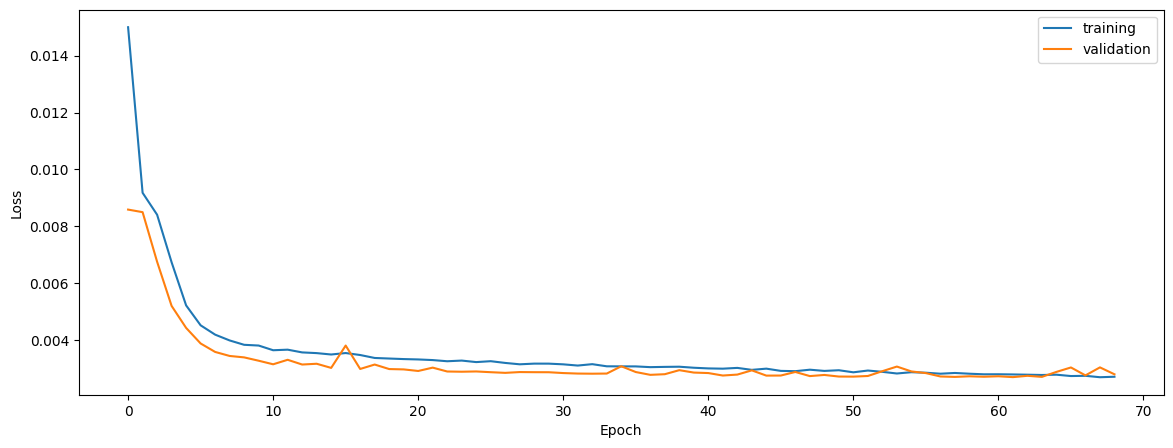

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8405602276141805
0.8305658241764519
0.8206271473398967


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8410011643725755
0.847213092625522
0.827524646382413


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8396315481573123
0.8439785480134083
0.8252445672464624


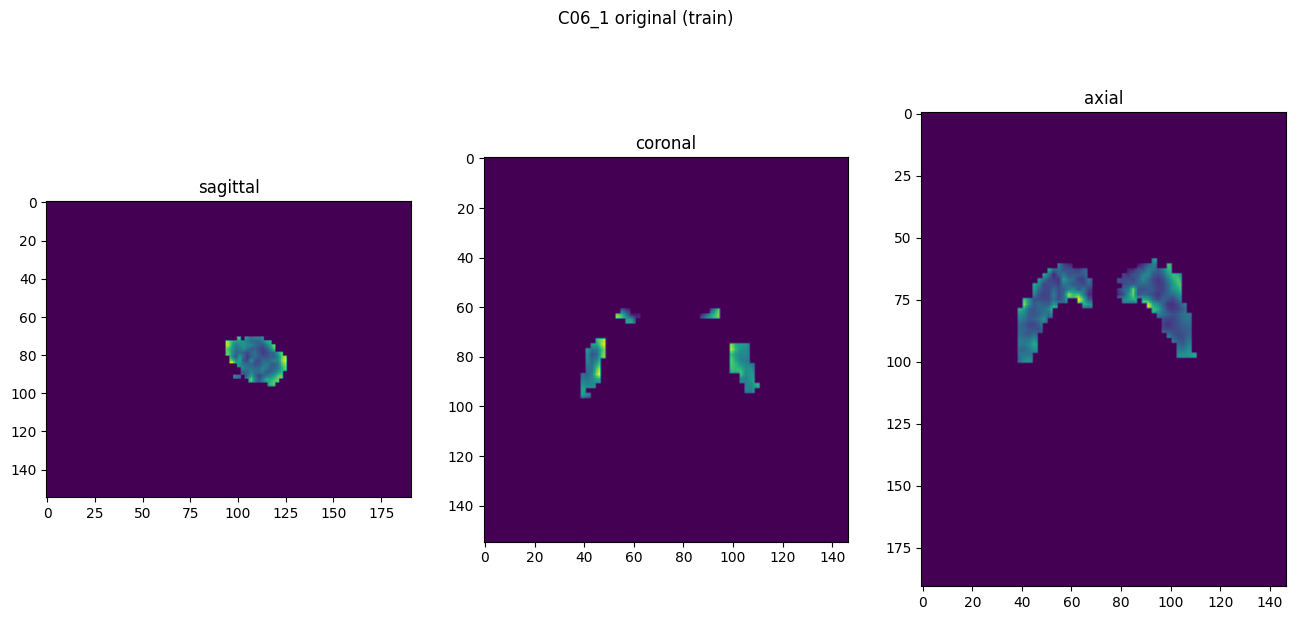

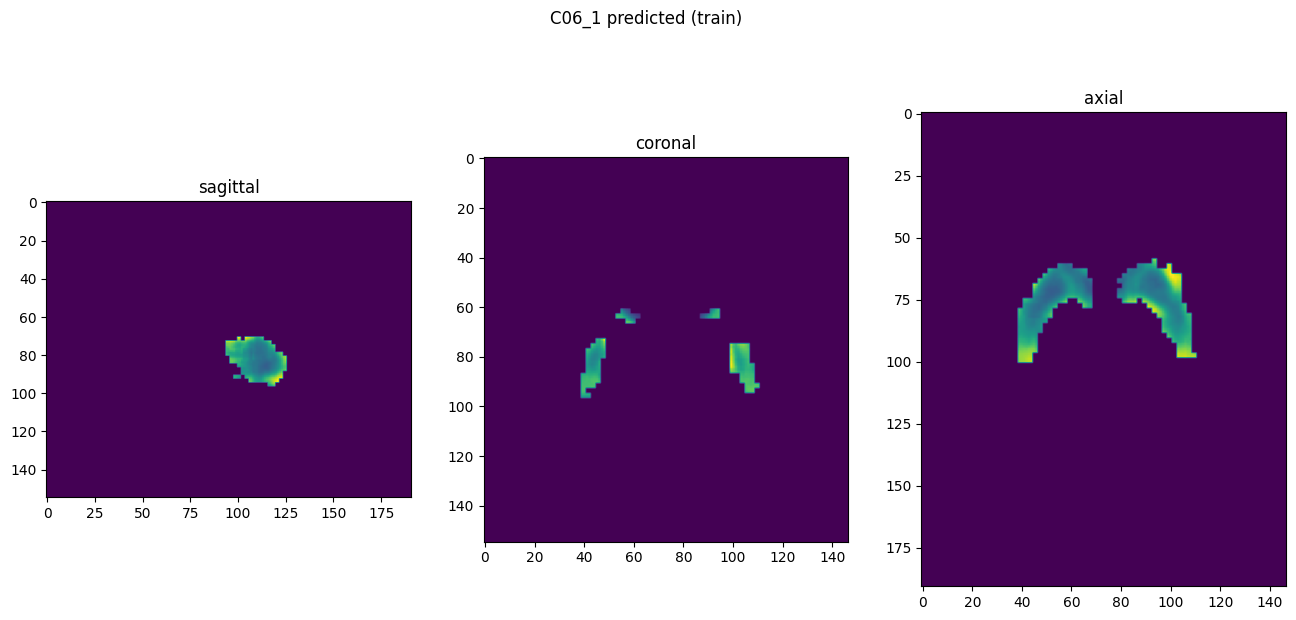

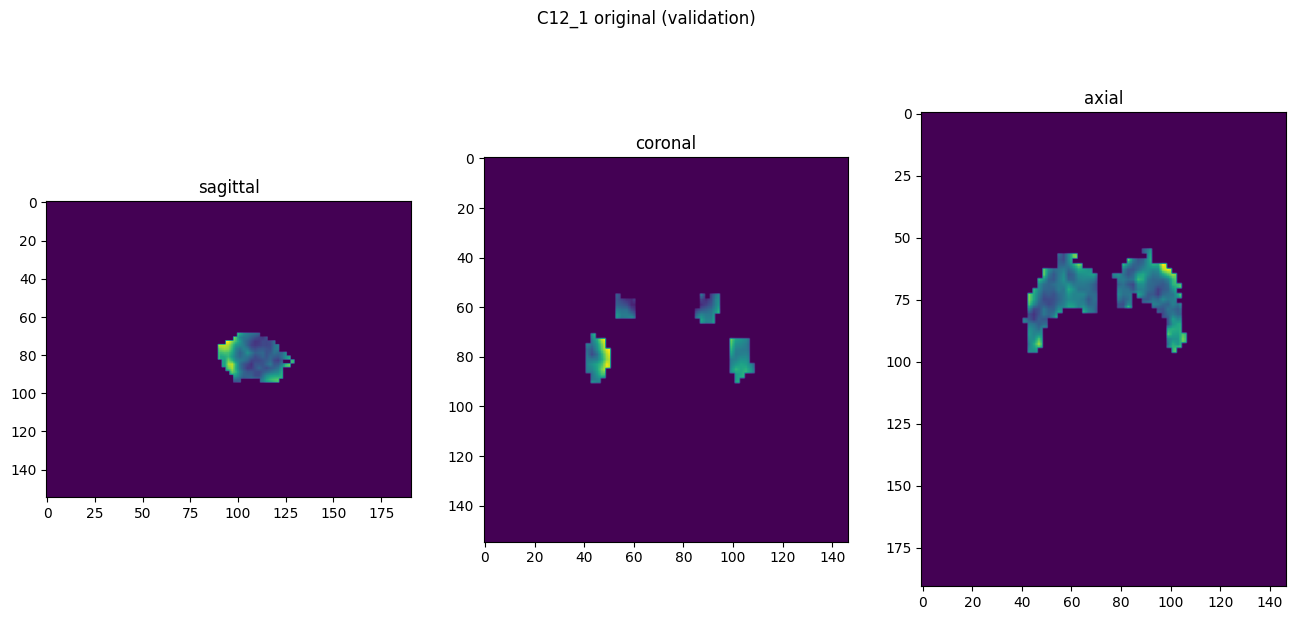

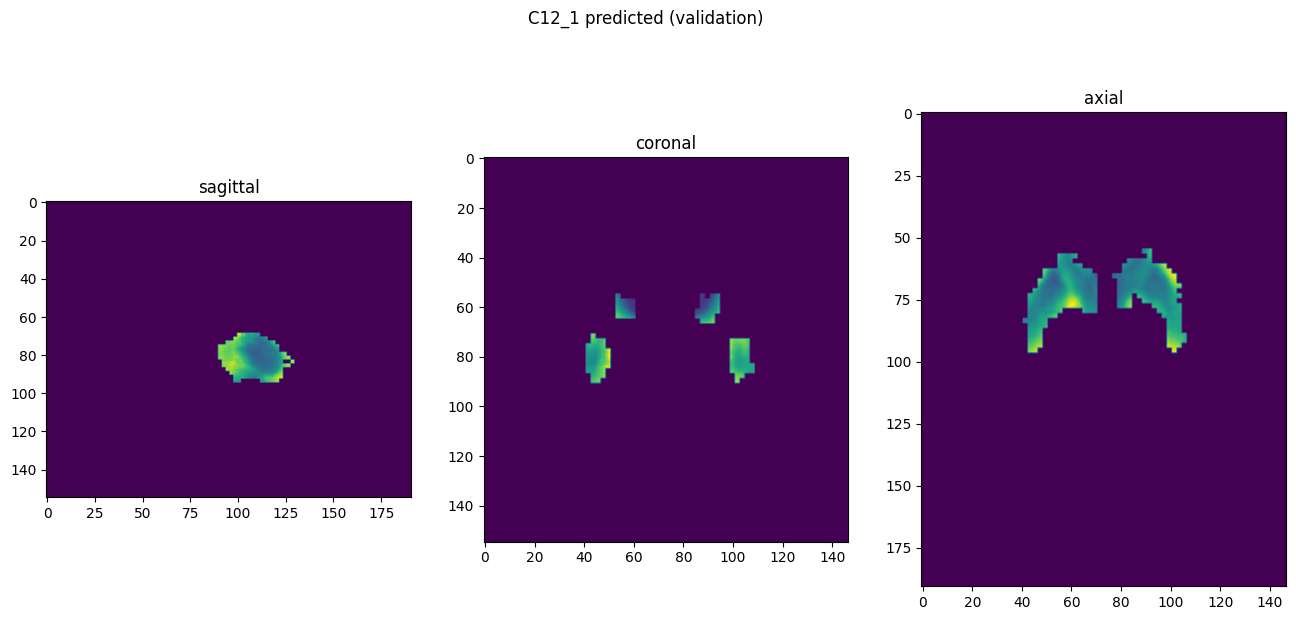

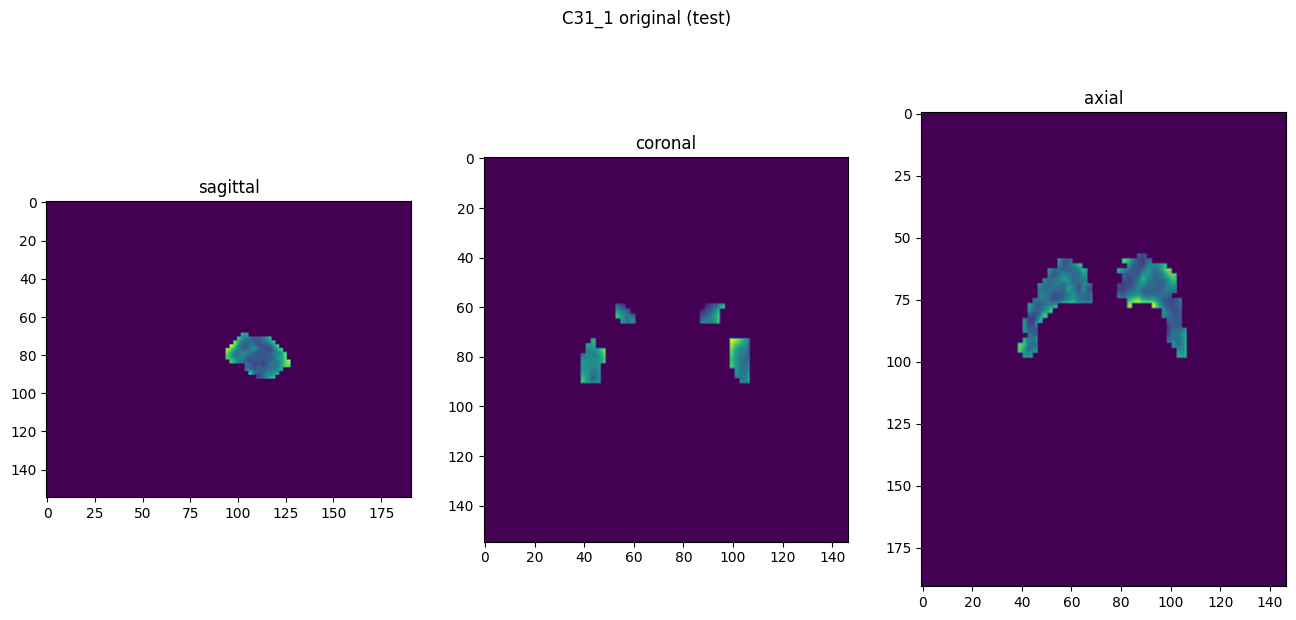

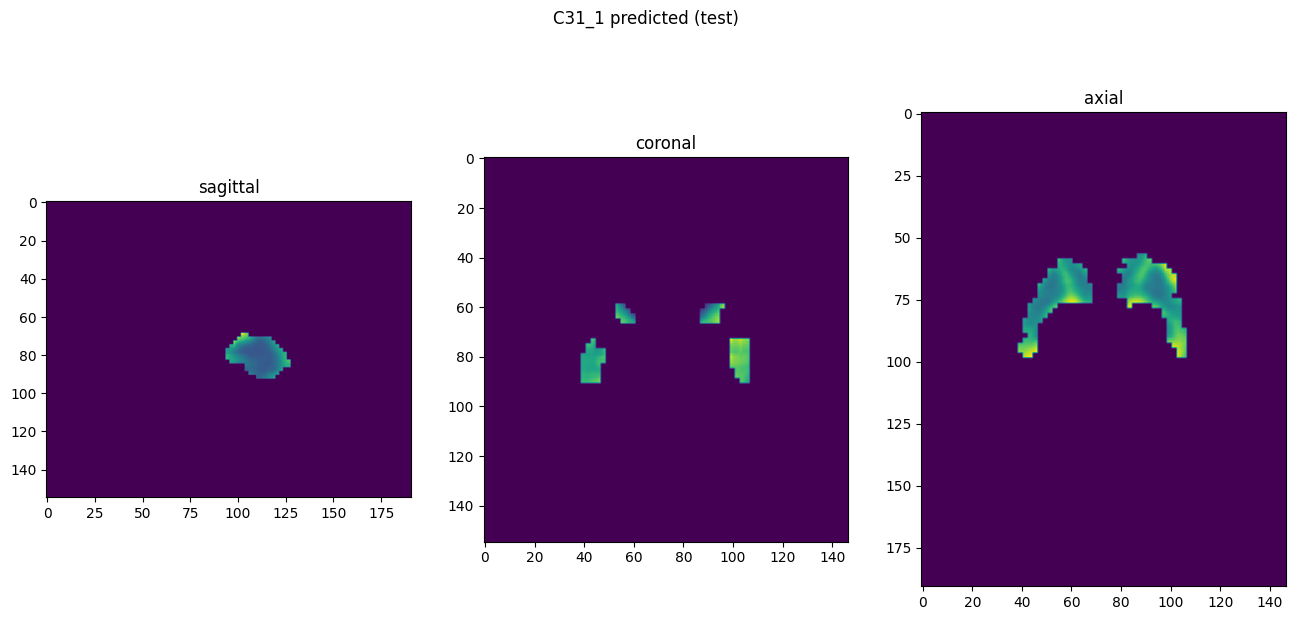

In [10]:
showResults(model, gen, threshold=None, background=False)